In [1]:
# Importazione delle librerie
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import curve_fit
import mplhep as hep
from cycler import cycler
import matplotlib.colors as colors
import multiprocessing.pool
from scipy.optimize import approx_fprime
import pandas as pd

In [27]:
# Definizione delle funzioni
def retta(x, a, b):
    return a + b*x

def fitlinA_2(x, a, b):
    return a + b/x

def fit_nl_Tf(x, ft):
    return 1/np.sqrt(1 + (x/ft)**2)

def fit_nl_phi(x, ft):
    return np.arctan((x)/ft)

In [28]:
# Impostazioni grafici
plt.style.use(hep.style.ROOT)
params = {'legend.fontsize': '12',
         'legend.loc': 'upper right',
          'legend.frameon':       'True',
          'legend.framealpha':    '0.8',      # legend patch transparency
          'legend.facecolor':     'w', # inherit from axes.facecolor; or color spec
          'legend.edgecolor':     'w',      # background patch boundary color
          'figure.figsize': (6, 4),
         'axes.labelsize': '12',
         'figure.titlesize' : '16',
         'axes.titlesize':'14',
         'xtick.labelsize':'12',
         'ytick.labelsize':'12',
         'lines.linewidth': '1',
         'text.usetex': True,
#         'axes.formatter.limits': '-5, -3',
         'axes.formatter.min_exponent': '2',
#         'axes.prop_cycle': cycler('color', 'bgrcmyk')
         'figure.subplot.left':'0.125',
         'figure.subplot.bottom':'0.125',
         'figure.subplot.right':'0.925',
         'figure.subplot.top':'0.925',
         'figure.subplot.wspace':'0.1',
         'figure.subplot.hspace':'0.1',
#         'figure.constrained_layout.use' : True
          }
plt.rcParams.update(params)
plt.rcParams['axes.prop_cycle'] = cycler(color=['b','g','r','c','m','y','k'])

In [29]:
# Importazione dei dati per fit globale
data = pd.read_csv('Dati.txt', sep="\t")

# I file devono essere formattati in questo modo:
# f	Vch2	sV	dT	sT
# con f [Hz], Vch2[V], sV[V], dT[us], sT[us]:
# - f, frequenze in ingresso [Hz]
# - Vch2, Ampiezza misurata ai capi della resistenza [V]
# - sV, scala della misura dell'ampiezza [V]
# - dT, differenza temporale fra 2 intersezioni con lo 0 V [us]
# - sT, scala della misura dei tempi [us]

f = data["f"]
phi = 2e-6 * np.pi * data["f"] * data["dT"] # in rapporto a 90°
sphi = 2e-6 * np.pi * data["f"] * np.sqrt(data["sT"]/(10*12**0.5))

Vin = 8.16 # V
sVin = np.sqrt((0.03*Vin/(24**0.5))**2+(1/(25*24**0.5))) # Assumo triangolare

Tf = data["Vch2"]/Vin
sTf = np.sqrt((0.03*data["Vch2"]/(12**0.5))**2+(1/(25*12**0.5)) + (data["Vch2"]/Vin * sVin)**2)/Vin # Assumo uniforme

frequenze = []
sfrequenze = []

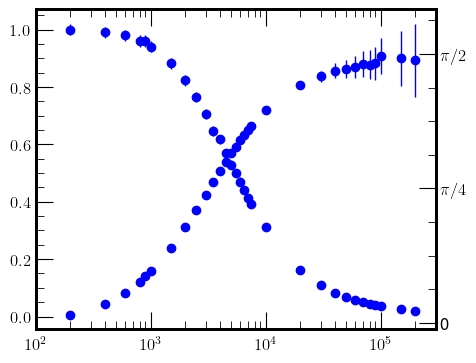

In [30]:
# Plot dei dati importati
fig, axA = plt.subplots(1,1, figsize=(5,4))
axA.errorbar(f, Tf, yerr=sTf , fmt='o')
axA.semilogx()
axF = axA.twinx()

axF.set_yticks((0, np.pi/4, np.pi/2))
labels = axF.set_yticklabels(('0', r'$\pi / 4$', r'$\pi / 2$'))

axF.errorbar(f, phi,  yerr= sphi, xerr=sphi , fmt='o')

axA.set_xlim(100,max(f)+10**5)

plt.show()

[3129.09064967] [[38.06771399]]
0.3282637938355356


[]

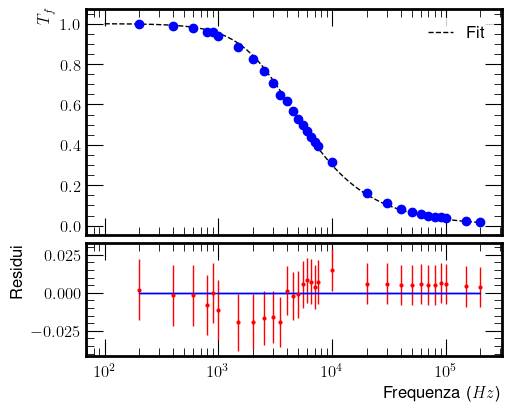

In [31]:
# Fit della funzione di trasferimento non lineare
valtr, covtr = curve_fit(fit_nl_Tf, f, Tf, p0=[3142], method='lm' ,sigma=sTf, absolute_sigma=True)
print(valtr, covtr**0.5)

resTr = Tf - fit_nl_Tf(f, *valtr)
chi2Tf = np.sum((resTr/sTf)**2)
print(chi2Tf/(len(f)-1))

x_fit = np.linspace(min(f)-100,max(f)+1e4, 10000)

frequenze.append(*valtr)
sfrequenze.append(np.sqrt(covtr[0,0]))

# Plot the first fit to define t0
fig, ax = plt.subplots(2, 1, figsize=(5, 4),sharex=True, constrained_layout = True, height_ratios=[2, 1])
ax[0].plot(x_fit, fit_nl_Tf(x_fit, *valtr), label='Fit', linestyle='--', color='black')
ax[0].errorbar(f, Tf, yerr=sTf , fmt='o')
ax[0].legend(loc='upper right')
ax[0].set_ylabel(r'$T_f$')

ax[1].errorbar(f,resTr,yerr=sTf, fmt='o', label='Residui',ms=2,color='red')
ax[1].set_ylabel('Residui')
ax[1].set_xlabel(r'Frequenza ($Hz$)')
ax[1].plot(f,np.zeros(len(f)))

ax[0].semilogx()

[3256.51541375] [[8.92904488]]
14.721741148844096


[]

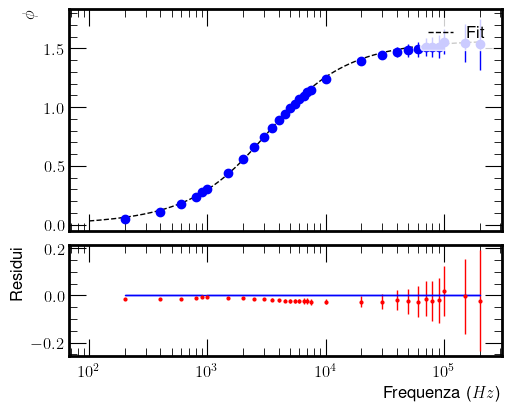

In [32]:
# Fit della fase non lineare
valphi, covphi = curve_fit(fit_nl_phi, f, phi, p0=[3106], method='lm' ,sigma=sphi, absolute_sigma=True)
print(valphi, covphi**0.5)

resPhi = phi - fit_nl_phi(f, *valtr)
chi2phi = np.sum((resPhi/sphi)**2)

print(chi2phi/(len(f)-1))

x_fit = np.linspace(min(f)-100,max(f)+1e4, 10000)

frequenze.append(*valphi)
sfrequenze.append(np.sqrt(covphi[0,0]))

# Plot the first fit to define t0
fig, ax = plt.subplots(2, 1, figsize=(5, 4),sharex=True, constrained_layout = True, height_ratios=[2, 1])
ax[0].plot(x_fit, fit_nl_phi(x_fit, *valphi), label='Fit', linestyle='--', color='black')

ax[0].errorbar(f, phi, yerr=sphi, fmt='o')
ax[0].legend(loc='upper right')
ax[0].set_ylabel(r'$\phi$')

ax[1].errorbar(f,resPhi,yerr=sphi, fmt='o', label='Residui',ms=2,color='red')

ax[1].set_ylabel('Residui')
ax[1].set_xlabel(r'Frequenza ($Hz$)')
ax[1].plot(f,np.zeros(len(f)))

ax[0].semilogx()


In [33]:
# Fit di Bode
valbode, covbode = curve_fit(retta, np.log10(f[f > 6e3]), 20*np.log10(Tf[f > 6e3]), method='lm' ,sigma=sTf[f > 6e3]/Tf[f > 6e3], absolute_sigma=True)

residuBode = Tf[f > 6e3] - 10**(retta(np.log10(f[f > 6e3]), *valbode)/20)
chi2bode = np.sum((residuBode/sTf[f > 6e3])**2)

print(chi2bode/(len(sTf[f > 6e3])-2))

print(valbode, '\n' , np.sqrt(np.diag(covbode)), '\n' , covbode) # Se voglio vedere i -20 dB su decade basta moltiplicare questo per 20

log_ftbode = (-valbode[0]/valbode[1])
slog_ftbode = log_ftbode * (covbode[0,0]/valbode[0]**2 + covbode[1,1]/valbode[1]**2 - 2*covbode[1,0]/(valbode[0]*valbode[1]))**0.5

frequenze.append(round(10**log_ftbode))
sfrequenze.append(round(10**(slog_ftbode+log_ftbode)-10**log_ftbode))


print(round(10**log_ftbode), '+/-', round(10**(slog_ftbode+log_ftbode)-10**log_ftbode))

0.0838829820786645
[ 62.2155291  -18.15887498] 
 [0.31039626 0.07868915] 
 [[ 0.09634584 -0.02438595]
 [-0.02438595  0.00619198]]
2668 +/- 15


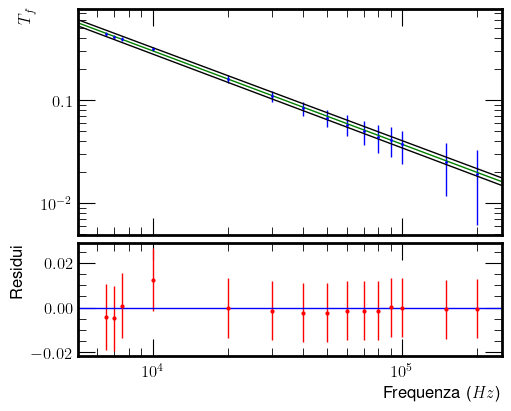

In [34]:
# Plot del fit di Bode
fig, ax = plt.subplots(2, 1, figsize=(5, 4),sharex=True, constrained_layout = True, height_ratios=[2, 1])

x_fit = np.linspace(5e3, max(f)+5e4, 1000)

ax[0].errorbar(f[f > 6e3], Tf[f > 6e3], yerr=sTf[f > 6e3], fmt='o', ms=1)

ax[0].plot(x_fit, 10**(retta(np.log10(x_fit), *valbode)/20), color = "g")
ax[0].plot(x_fit, 10**(retta(np.log10(x_fit), *(valbode+np.sqrt(np.diag(covbode))))/20), color = "k")
ax[0].plot(x_fit, 10**(retta(np.log10(x_fit), *(valbode-np.sqrt(np.diag(covbode))))/20), color = "k")
ax[0].set_ylabel(r'$T_f$')

ax[0].set_xlim(5e3, max(f)+5e4)

ax[0].loglog()

ax[1].errorbar(f[f > 6e3],residuBode,yerr=sTf[f > 6e3], fmt='o', label='Residui',ms=2,color='red')
ax[1].set_ylabel('Residui')
ax[1].set_xlabel(r'Frequenza ($Hz$)')
ax[1].plot(x_fit,np.zeros(len(x_fit)))



Dalla funzione di trasferimento:
ft = 3163.7336 ± 41.4322 Hz
a = 1.0238 ± 0.0165
Chi² ridotto = 0.2862

Dalla fase:
ft = 3155.3209 ± 11.5620 Hz
a = -0.0129 ± 0.0010
Chi² ridotto = 2.5112


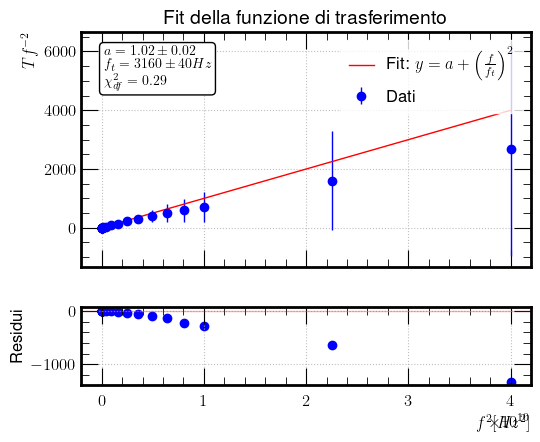

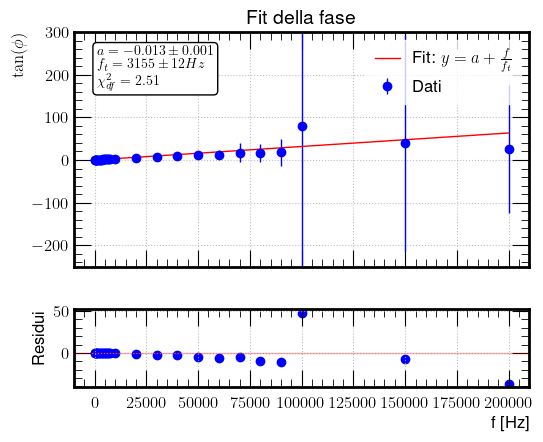

In [57]:
def fit_funzione_trasferimento(f, Tf, sTf):
    # Calcoliamo Tf^-2 e la sua incertezza
    Tf_inv_squared = 1.0 / (Tf**2)
    # Propagazione dell'errore per 1/Tf^2: σ(1/Tf^2) = 2*sTf/(Tf^3)
    sTf_inv_squared = 2.0 * sTf / (Tf**3)
    
    # Prepariamo x come f**2 per il fit lineare
    x = f**2
    
    # Eseguiamo il fit
    params, pcov = curve_fit(retta, x, Tf_inv_squared, sigma=sTf_inv_squared, absolute_sigma=True)
    
    # Estraiamo i parametri e le incertezze
    a, b = params
    a_err, b_err = np.sqrt(np.diag(pcov))
    
    # Calcoliamo ft e la sua incertezza
    ft = 1.0 / np.sqrt(b)
    # Propagazione dell'errore per ft = 1/sqrt(b): σ(ft) = 0.5 * b_err / (b^(3/2))
    ft_err = 0.5 * b_err / (b**(3/2))
    
    # Calcoliamo i valori previsti dal modello
    y_fit = retta(x, a, b)
    
    # Calcoliamo i residui normalizzati
    residui = (Tf_inv_squared - y_fit)
    
    # Calcoliamo il chi quadro
    chi2 = np.sum((residui/sTf_inv_squared)**2)
    
    # Calcoliamo il chi quadro ridotto (chi2 / dof)
    dof = len(x) - 2  # gradi di libertà (numero di dati - numero di parametri)
    chi2_ridotto = chi2 / dof if dof > 0 else np.nan
    
    return a, a_err, ft, ft_err, params, pcov, chi2_ridotto, residui, y_fit

# Per la seconda equazione: tan(phi) = a + f/ft
# Riscriviamo come: tan(phi) = a + b*f dove b = 1/ft

def fit_fase(f, phi, sphi):
    # Calcoliamo tan(phi) e la sua incertezza
    tan_phi = np.tan(phi)
    # Propagazione dell'errore per tan(phi): σ(tan(phi)) = sphi / (cos(phi))^2
    stan_phi = sphi / (np.cos(phi))**2
    
    # Eseguiamo il fit
    params, pcov = curve_fit(retta, f, tan_phi, sigma=stan_phi, absolute_sigma=True)
    
    # Estraiamo i parametri e le incertezze
    a, b = params
    a_err, b_err = np.sqrt(np.diag(pcov))
    
    # Calcoliamo ft e la sua incertezza
    ft = 1.0 / b
    # Propagazione dell'errore per ft = 1/b: σ(ft) = b_err / b^2
    ft_err = b_err / (b**2)
    
    # Calcoliamo i valori previsti dal modello
    y_fit = retta(f, a, b)
    
    # Calcoliamo i residui normalizzati
    residui = (tan_phi - y_fit)
    
    # Calcoliamo il chi quadro
    chi2 = np.sum((residui/stan_phi)**2)
    
    # Calcoliamo il chi quadro ridotto (chi2 / dof)
    dof = len(f) - 2  # gradi di libertà (numero di dati - numero di parametri)
    chi2_ridotto = chi2 / dof if dof > 0 else np.nan
    
    return a, a_err, ft, ft_err, params, pcov, chi2_ridotto, residui, y_fit

# Funzione per visualizzare i risultati con residui e chi2
def plot_results(f, Tf, sTf, phi, sphi, params_Tf, chi2_Tf, residui_Tf, y_fit_Tf, params_phi, chi2_phi, residui_phi, y_fit_phi, ft_Tf, ft_err_Tf, a_Tf, a_err_Tf, ft_phi, ft_err_phi, a_phi, a_err_phi):
    # Creiamo figure con subplot per funzione di trasferimento e residui
    fig1, (ax1, ax3) = plt.subplots(2, 1, figsize=(6, 5), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
    
    # Plot per la funzione di trasferimento
    x_data_Tf = f**2
    y_data_Tf = 1.0/(Tf**2)
    yerr_Tf = 2.0*sTf/(Tf**3)
    
    x_fit = np.linspace(min(x_data_Tf), max(x_data_Tf), 100)
    y_fit = retta(x_fit, params_Tf[0], params_Tf[1])
    
    ax1.errorbar(x_data_Tf, y_data_Tf, yerr=yerr_Tf, fmt='o', label='Dati')
    ax1.plot(x_fit, y_fit, 'r-', label=r'Fit: $y = a + \left(\frac{f}{f_t}\right)^2$')
    
    # Aggiungiamo textbox con i parametri del fit
    textstr = '\n'.join((
        r'$a = %.2f \pm %.2f$' % (a_Tf, a_err_Tf),
        r'$f_t = %.f \pm %.f Hz$' % (round(ft_Tf, -1), round(ft_err_Tf,-1)),
        r'$\chi^2_{df} = %.2f$' % (chi2_Tf,)))
    props = dict(boxstyle='round', facecolor='white', alpha=1)
    ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)
    
    ax1.set_ylabel(r'$Tf^{-2}$')
    ax1.legend()
    ax1.grid(True)
    ax1.set_title('Fit della funzione di trasferimento')
    
    # Plot dei residui
    ax3.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    ax3.scatter(x_data_Tf, residui_Tf)
    ax3.grid(True)
    ax3.set_xlabel(r'$f^2 [Hz^2]$ ~~~~~~~~~~~~~~~')
    ax3.set_ylabel('Residui')
    
    plt.tight_layout()
    
    # Creiamo figure con subplot per fase e residui
    fig2, (ax2, ax4) = plt.subplots(2, 1, figsize=(6, 5), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
    
    # Plot per la fase
    x_data_phi = f
    y_data_phi = np.tan(phi)
    yerr_phi = sphi/(np.cos(phi))**2
    
    x_fit_phi = np.linspace(min(f), max(f), 100)
    y_fit_phi = retta(x_fit_phi, params_phi[0], params_phi[1])
    
    ax2.errorbar(x_data_phi, y_data_phi, yerr=yerr_phi, fmt='o', label='Dati')
    ax2.plot(x_fit_phi, y_fit_phi, 'r-', label=r'Fit: $y = a + \frac{f}{f_t}$')
    
    # Aggiungiamo textbox con i parametri del fit
    textstr = '\n'.join((
        r'$a = %.3f \pm %.3f$' % (a_phi, a_err_phi),
        r'$f_t = %.f \pm %.f Hz$' % (round(ft_phi), round(ft_err_phi)),
        r'$\chi^2_{df} = %.2f$' % (chi2_phi,)))
    props = dict(boxstyle='round', facecolor='white', alpha=1)
    ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)
    
    ax2.set_ylabel(r'$\tan(\phi)$')
    ax2.legend()
    ax2.grid(True)
    ax2.set_title('Fit della fase')

    ax2.set_ylim(-250, 300)
    
    # Plot dei residui
    ax4.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    ax4.scatter(x_data_phi, residui_phi)
    ax4.grid(True)
    ax4.set_xlabel('f [Hz]')
    ax4.set_ylabel('Residui')
    
    plt.tight_layout()
    plt.show()
    
    return fig1, fig2

# Esegui i fit
a_Tf, a_err_Tf, ft_Tf, ft_err_Tf, params_Tf, _, chi2_Tf, residui_Tf, y_fit_Tf = fit_funzione_trasferimento(f, Tf, sTf)
a_phi, a_err_phi, ft_phi, ft_err_phi, params_phi, _, chi2_phi, residui_phi, y_fit_phi = fit_fase(f, phi, sphi)

# Stampa i risultati
print(f"Dalla funzione di trasferimento:")
print(f"ft = {ft_Tf:.4f} ± {ft_err_Tf:.4f} Hz")
print(f"a = {a_Tf:.4f} ± {a_err_Tf:.4f}")
print(f"Chi² ridotto = {chi2_Tf:.4f}")
print("\nDalla fase:")
print(f"ft = {ft_phi:.4f} ± {ft_err_phi:.4f} Hz")
print(f"a = {a_phi:.4f} ± {a_err_phi:.4f}")
print(f"Chi² ridotto = {chi2_phi:.4f}")

# Visualizza i risultati
fig1, fig2 = plot_results(f, Tf, sTf, phi, sphi, params_Tf, chi2_Tf, residui_Tf, y_fit_Tf, 
                         params_phi, chi2_phi, residui_phi, y_fit_phi, 
                         ft_Tf, ft_err_Tf, a_Tf, a_err_Tf, 
                         ft_phi, ft_err_phi, a_phi, a_err_phi)

frequenze.append(ft_Tf)
frequenze.append(ft_phi)
sfrequenze.append(ft_err_Tf)
sfrequenze.append(ft_err_phi)


In [ ]:
# Plot dei dati
fig, axA = plt.subplots(2,1, figsize=(5,4),sharex=True, constrained_layout = True, height_ratios=[2, 1])
x_fit = np.linspace(min(f**2),max(f**2),100)

axA[0].errorbar(f**2, A_2, yerr=sA_2, fmt='bo')
axA[0].plot(x_fit, retta(x_fit, *poptrlin), color = "b")

axA[1].errorbar(f**2, resA_2, yerr=sA_2, fmt='bo')
axA[1].plot(x_fit, np.zeros(100), color = "b")


plt.show()

In [ ]:
x_fit = np.linspace(min(f),100000,100)

fig, axA = plt.subplots(2,1, figsize=(5,4),sharex=True, constrained_layout = True, height_ratios=[2, 1])

axA[0].plot(x_fit, retta(x_fit, *popphilin), color = "g")
axA[0].errorbar(f[f<100000], tgphi[f<100000],  yerr= stgphi[f<100000], fmt='go')

axA[1].errorbar(f[f<100000], restgPhilin[f<100000], yerr=stgphi[f<100000], fmt='go')
axA[1].plot(x_fit, np.zeros(100), color = "b")

plt.show()


In [38]:
# Importo il file con solo i dati locali intorno della frequenza di taglio
data = pd.read_csv('Dati locali.txt', sep="\t")
floc = data["f"]/1000 #kHz
philoc = 2e-6 * np.pi * data["f"] * data["dT"] # in rapporto a 90°
sphiloc = 2e-6 * np.pi * data["f"] * np.sqrt(data["sT"]/(10*12**0.5))

Vin = 8.16 # V
sVin = np.sqrt((1/(25*24**0.5)))

Tfloc = data["Vch2"]/Vin
sTfloc = np.sqrt(((1/(25*24**0.5)) + (data["Vch2"]/Vin * sVin)**2))/Vin # Assumo triangolare

In [39]:
# Fit linearizzato della f. di trasferimento in un intorno della ft (freq. di taglio)
valtrlin, covtrlin = curve_fit(retta, floc, Tfloc, method='lm' ,sigma=sTfloc, absolute_sigma=True)

a,b = valtrlin

ft_tr_lin = (2**-0.5 - a)/b

s_ft_tr_lin = np.sqrt((1/np.sqrt(2)-valtrlin[0])**2/valtrlin[1]**4*covtrlin[1,1]+1/valtrlin[1]**2*covtrlin[0,0]+2/valtrlin[1]**3*(1/np.sqrt(2)-valtrlin[0])*covtrlin[0,1])

frequenze.append(ft_tr_lin  * 10**3)
sfrequenze.append(s_ft_tr_lin * 10**3)

print(ft_tr_lin,"+/-",s_ft_tr_lin, "kHz")

residutrlin = Tfloc - retta(floc, *valtrlin)
chi2lintr = np.sum((residutrlin/Tfloc)**2)

df = len(floc)-2

print(chi2lintr/df)

3.042127749639824 +/- 0.0417924088683911 kHz
5.6100422234539035e-05


In [40]:
# Fit linearizzato della fase in un intorno della ft (freq. di taglio)
valphilin, covphilin = curve_fit(retta, floc, philoc, method='lm' ,sigma=sphiloc, absolute_sigma=True)

residuPhilin = philoc - retta(floc, *valphilin)
chi2linPhi = np.sum((residuPhilin/sphiloc)**2)

df = len(floc)-2

print(chi2linPhi/df)

a,b = valphilin

ft_phi_lin = (np.pi/4 - a)/b

s_ft_phi_lin = np.sqrt((np.pi/4-valphilin[0])**2/valphilin[1]**4*covphilin[1,1]+1/valphilin[1]**2*covphilin[0,0]+2/valphilin[1]**3*(np.pi/4-valphilin[0])*covphilin[0,1])


frequenze.append(ft_phi_lin  * 10**3)
sfrequenze.append(s_ft_phi_lin * 10**3)


print(ft_phi_lin,"+/-",s_ft_phi_lin, "kHz")


0.3366460745676681
3.436031652740748 +/- 0.05888801648303126 kHz


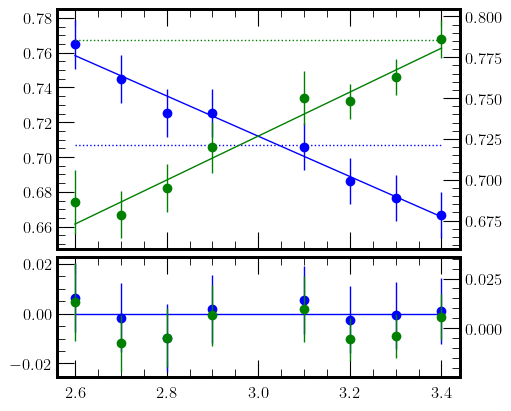

In [41]:
# Plot dei dati
fig, axA = plt.subplots(2,1, figsize=(5,4),sharex=True, constrained_layout = True, height_ratios=[2, 1])
x_fit = np.linspace(min(floc),max(floc),100)
h = 0.1

axF = axA[0].twinx()

axA[0].errorbar(floc, Tfloc, yerr=sTfloc, fmt='bo')
axA[0].plot(x_fit, retta(x_fit, *valtrlin), color = "b")

axA[0].plot(x_fit, np.full(len(x_fit), 2**-0.5), linestyle = "dotted")

axF.plot(x_fit, retta(x_fit, *valphilin), color = "g")
axF.plot(x_fit, np.full(len(x_fit), np.pi/4), linestyle = "dotted", color = "g")

axF.errorbar(floc, philoc,  yerr= sphiloc, fmt='go')

axF2 = axA[1].twinx()


axA[1].errorbar(floc, residutrlin, yerr=sTfloc, fmt='bo')
axF2.errorbar(floc, residuPhilin, yerr=sphiloc, fmt='go')

axA[1].plot(x_fit, np.zeros(100), color = "b")


plt.show()

In [42]:
print((ft_phi_lin - ft_tr_lin)/np.sqrt(s_ft_phi_lin ** 2 + s_ft_tr_lin ** 2))

5.454914516272848


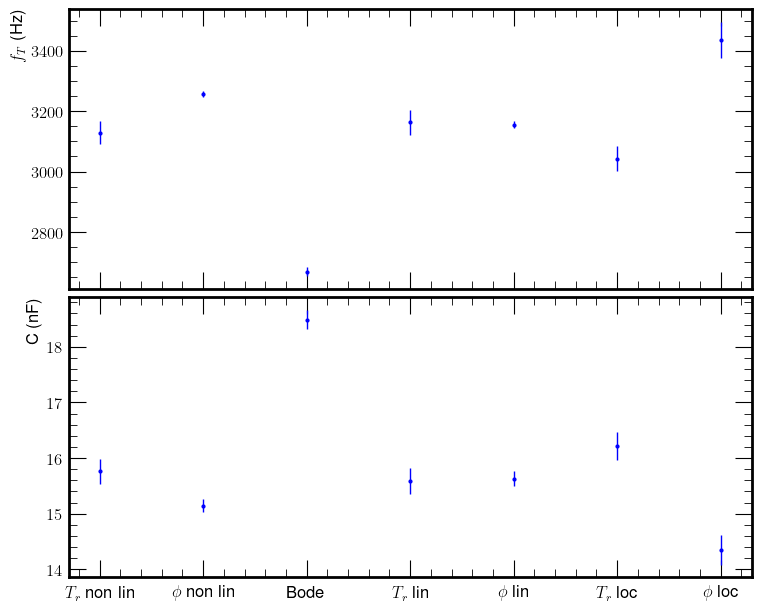

In [51]:
R = 3227
sR = 24

capacita = (2 * np.pi * R * np.array(frequenze))**-1
scapacita = capacita * np.sqrt((np.array(sfrequenze)/np.array(frequenze)) ** 2  + (sR/R)**2)

fig, ax = plt.subplots(2,1, figsize=(6,4),sharex=True, constrained_layout = True, height_ratios=[1, 1])
x_f = np.arange(0,len(frequenze))
ax[0].errorbar(x_f, frequenze, yerr = sfrequenze, fmt = 'o', ms = 2)
ax[1].errorbar(x_f, capacita*10**9, yerr = scapacita*10**9, fmt = 'o', ms = 2)

ax[0].set_ylabel(r"$f_T$ (Hz)")
ax[1].set_ylabel(r"C (nF)")

my_xticks = [r'$T_r$ non lin', r'$\phi$ non lin', r'Bode', r'$T_r$ lin', r'$\phi$ lin', r'$T_r$ loc', r'$\phi$ loc']
plt.xticks(x_f, my_xticks)

plt.show()
